# HDBSCAN - Tuning HDBSCAN parameters and running clustering

# Inputs
- Absolute path to the directory with .csv files
- Absolute path to the shapefile for your geography
- Absolute path to the shapefile for your geofile

```
!pip install --upgrade pip
!pip install fuzzywuzzy
!conda install -c conda-forge pyshp
!conda install -c conda-forge pyproj
!conda install -c conda-forge proj4
```

In [6]:
import os
import glob
import conda
import hdbscan
import operator
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from config import Config
from collections import Counter
from matplotlib import pyplot as plt
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection

In [28]:
DATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/utils/cluster'
SHAPEFILE = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/geo_files/gadm36_BGD_shp/gadm36_BGD_2'
GEOFILE = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_17/MSVSB PSU 2015.xlsx'
OUTPUT = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/other/test'
GEO_LEVEL = 'districts'

In [90]:
def get_files_list(input_dir):
    input_files = glob.glob(input_dir + "/*.csv")
    return input_files


def read_data(files_list):
    data_dict = {}
    for file in files_list:
        data_dict[file] = pd.read_csv(file)
    return data_dict


def check_type(ddict):
    check_list = []
    for key, df in ddict.items():
        df_check_list = [var == 'int64' or var == 'float64' for var in df.dtypes]
        check_list.append(all(df_check_list))
    return all(check_list)


def check_geovar(ddict):
    check_list = []
    for key, df in ddict.items():
        if df.columns[0] == 'geo':
            check_list.append(True)
        else:
            check_list.append(False)
    return all(check_list) 


def check_data(ddict):
    return check_type(ddict) and check_geovar(ddict)


def concat_data1(ddict):
    dlist = []
    for key, df in ddict.items():
        df['year'] = key[-8:-4]
        try:
            df['year'] = df['year'].astype(int)
        except ValueError:
            print("No year number in file names")
        dlist.append(df)
    out = pd.concat(dlist,axis=0)
    out['geo'] = out['geo'].astype(str).str.cat(out['year'].astype(str), sep=" ")
    out = out.drop(['year'], axis=1)
    return out


def concat_data2(ddict):
    dlist = []
    for key, df in ddict.items():
        df['year'] = key[-8:-4]
        try:
            df['year'] = df['year'].astype(int)
        except ValueError:
            print("No year number in file names")
        dlist.append(df)
    out = pd.concat(dlist,axis=0)
    if Counter([len(str(var)) for var in out['geo']]) != 1:
        out['geo'] = out['geo'].astype(str).str.pad(width=2, side='left', fillchar='0')
    return out


def create_output_dir(output_dir):
    dir_list = [name for name in os.listdir(os.path.split(output_dir)[0]) if os.path.isdir(name)]
    if os.path.split(output_dir)[1] not in dir_list:
        os.mkdir(os.path.split(output_dir)[1])
    else:
        print("Directory already present!")


def evaluate_hdbscan(input_df, min_samples, min_cluster_size, output, prune=True, plot=True):
    samples = list(itertools.product(min_samples, min_cluster_size))
    counter = 0
    models = pd.DataFrame(columns=['min_samples',
                                   'min_cluster_size',
                                   'num_clusters_including_unclustered',
                                   'number_of_unclustered_geos',
                                   'percent_of_unclustered_geos',
                                   'percent_of_maxclass',],index=range(len(samples)))
    df = input_df.copy(deep=True)
    geo = df['geo']
    df = df.drop('geo', axis=1)
    for iteration in samples:
        model = hdbscan.HDBSCAN(min_samples=int(iteration[0]), min_cluster_size=int(iteration[1]), metric='euclidean',algorithm='best').fit(df)
        models.loc[counter,'min_cluster_size'] = iteration[0]
        models.loc[counter, 'min_samples'] = iteration[1]
        models.loc[counter, 'num_clusters_including_unclustered'] = len(Counter(model.labels_))
        tmp_dict = dict(Counter(model.labels_))
        total = sum([v for k,v in tmp_dict.items()])
        tmp_dict = {k:round(v/total*100,2) for k,v in tmp_dict.items()}
        try:
            models.loc[counter, 'percent_of_unclustered_geos'] = tmp_dict.pop(-1)
        except KeyError as error:
            models.loc[counter, 'percent_of_unclustered_geos'] = 0 
        if len(tmp_dict) > 1:
            models.loc[counter, 'percent_of_maxclass'] = tmp_dict[max(tmp_dict.items(), key=operator.itemgetter(1))[0]]
        else:
            models.loc[counter, 'percent_of_maxclass'] = 100
        models.loc[counter, 'number_of_unclustered_geos'] = Counter(model.labels_)[-1]
        df['class'] = pd.Categorical(model.labels_)
        counter += 1
    if prune:
        models = models[models['number_of_unclustered_geos'] < (models.shape[0]/2)]
        models = models[models['num_clusters_including_unclustered'] > 3]
        models = models.sort_values(by='number_of_unclustered_geos')
    else:
        pass
    models.to_csv(os.path.split(output)[1] + "/models_overview.csv", index=False, index_label=False)
    if plot:
        plt.rcParams['figure.figsize'] = [20,10]
        # plt.plot(models['min_cluster_size'], label='Minimum cluster size')
        # plt.plot(models['min_samples'], label='Minimum sample')
        plt.plot(models['num_clusters_including_unclustered'], label='Number of clusters including unclustered')
        plt.plot(models['number_of_unclustered_geos'], label='Number of unassigned geos')
        plt.savefig(os.path.split(output)[1] + "/finetune_parameteres.jpeg")
        plt.legend()
        plt.show()
    return models


def cluster_data(input_df, f_min_samples, f_min_cluster_size):
    df = input_df.copy(deep=True)
    cluster_data = df.drop(['geo', 'year'], axis=1)
    model = hdbscan.HDBSCAN(min_samples=int(f_min_samples), 
                            min_cluster_size=int(f_min_cluster_size), 
                            metric='euclidean', 
                            algorithm='best').fit(cluster_data)
    df['class'] = model.labels_
    return df
    

def create_mapobject(shp_path, shp_name):
    m = Basemap(llcrnrlon=87.8, llcrnrlat=20.3, urcrnrlon=94, urcrnrlat=27, resolution='c')
    m.readshapefile(shapefile=shp_path, name=shp_name, drawbounds=True)
    return m


def colors2clusters(df_input, cluster_var):
    df = df_input.copy(deep=True)
    df['colors'] = df[cluster_var].astype('category')
    labs = list(df['colors'].cat.categories)
    clusters = list(df[cluster_var].unique())
    colors = sns.color_palette('Paired', len(clusters)).as_hex()
    df['colors'] = df['colors'].cat.rename_categories(colors)
    cols = list(df['colors'].cat.categories)
    return df, list(zip(labs,cols))


def data2map(mapobj, mapobj_key, data, data_key):
    for district in mapobj.districts_info:
        district['CLUSTER'] = data.loc[data[data_key] == district[mapobj_key],'colors'][0]
    return mapobj


def plot_geos(mapobj, mapobj_key, labels_colors, title, output):
    geo_names = []
    for shape_dict in mapobj.districts_info:
        geo_names.append(int(shape_dict[mapobj_key]))
    ax = plt.gca()
    for info, shape in zip(mapobj.districts_info, mapobj.districts):
        poly = Polygon(shape, facecolor=info['CLUSTER'], edgecolor=info['CLUSTER'])
        ax.add_patch(poly)
    legend_elements = [Line2D([0], [0], marker="s", color=col, label=label, markerfacecolor=col, markersize=25)
                   for label, col in labels_colors] 
    plt.legend(handles=legend_elements, loc='upper right',borderpad=2)
    plt.title(title)
    plt.savefig(os.path.join(output, title + ".jpeg"))
    plt.show()
    plt.close()


def plot_clusters(input_df, shapefile, geo_level, project, output):
    df = input_df.copy(deep=True)
    plt.rcParams['figure.figsize'] = [10,10]
    for year in sorted(list(df['year'].unique())):
        m = create_mapobject(shp_path=shapefile,shp_name=geo_level)
        tmp = df[df['year'] == year]
        print(tmp['year'].unique())
        m = data2map(mapobj=m, mapobj_key='CC_2', data=tmp, data_key='geo')
        plot_geos(mapobj=m, mapobj_key='CC_2',labels_colors=labs_cols, title=project + str(year), output=output)
    

def get_statistics(input_df, output, title):
    df = input_df.copy(deep=True)
    out = {}
    for year in df['year'].unique():
        tmp = df[df['year'] == year]
        variables = list(tmp.drop(['year', 'geo', 'class', 'colors'], axis=1).columns)
        tmp = tmp.drop(['year','geo'], axis=1)
        tmpgroupby = tmp.groupby('class')
        output_year = [] 
        for variable in variables:
            print(variable)
            tmp = tmpgroupby[variable].agg([np.mean, np.std, np.max, np.min]).transpose()
            tmp['var'] = variable
            output_year.append(tmp)
        out[year] = pd.concat(output_year, axis=0)
        out[year].to_csv(os.path.join(output, title+"_" +str(year) + ".csv"),index=False, index_label=False)
    return out


def update_geo(input_df, input_geo):
    df = input_df.copy(deep=True)
    geodata = pd.read_excel(input_geo, sheet_name="PSU 2012")
    geodata['dv'] = geodata['dv'].astype(str)
    geodata['zl'] = geodata['zl'].astype(str)
    geodata['dv'] = geodata['dv'].str.pad(width=2,side='left',fillchar='0')
    geodata['zl'] = geodata['zl'].str.pad(width=2,side='left',fillchar='0')
    geodata['geo_full'] = geodata['dv'].str.cat(geodata['zl'], sep='')
    geodata = geodata[['geo_full','dv','Div_Name','zl','Zila_Name']]
    geodata = geodata.drop_duplicates()
    print(input_df.shape)
    df = df.merge(right=geodata, left_on='geo', right_on='zl')
    print(df.shape)
    df = df.drop(['dv', 'Div_Name', 'zl', 'Zila_Name', 'geo'], axis=1)
    df.rename(columns={'geo_full':'geo'}, inplace=True)
    return df

## PART 1: Fine-tuning the clustering model
### STEP 1: Get files list

In [70]:
dfiles = get_files_list(input_dir=DATA)
dfiles

['/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/utils/cluster/demo_2015.csv',
 '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/utils/cluster/demo_2016.csv',
 '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/utils/cluster/demo_2017.csv']

### STEP 2: Read data

In [71]:
ddata = read_data(files_list=dfiles)

### STEP 3: Check data 

In [72]:
dcheck = check_data(ddict=ddata)

### STEP 4: Concat data 

In [73]:
ddf = concat_data1(ddict=ddata)

### STEP 5: Create output dir

In [74]:
create_output_dir(output_dir=OUTPUT)

Directory already present!


### STEP 6: Fine tune and analyze the data and obtain the output of paramaters

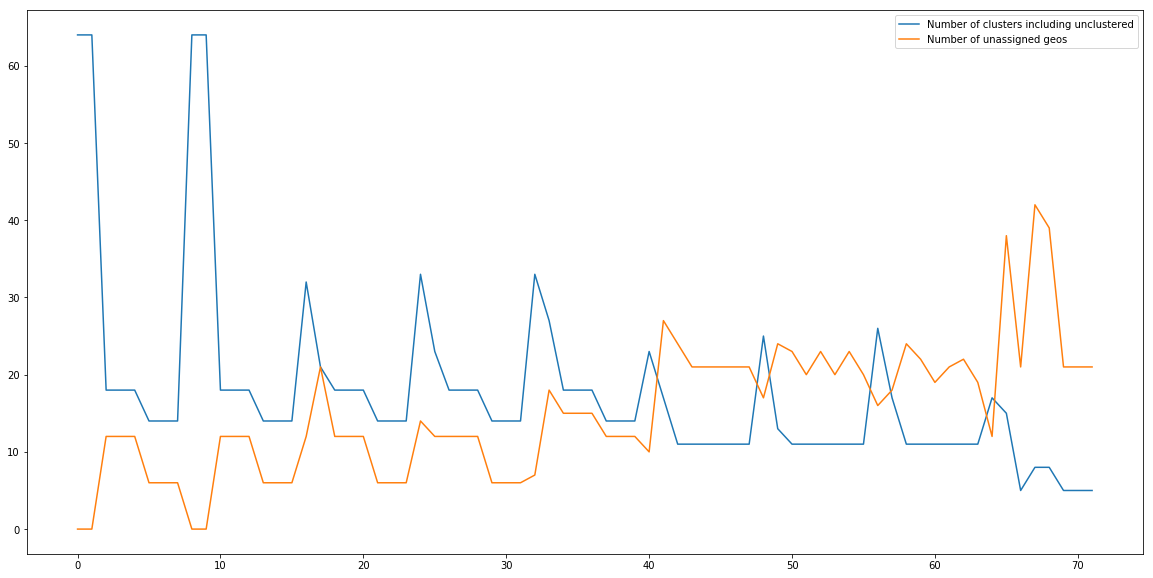

In [75]:
tmp = evaluate_hdbscan(input_df=ddf, 
                       min_samples=Config.tune_min_sample, 
                       min_cluster_size=Config.tune_min_cluster,
                       output=OUTPUT, prune=False)

In [76]:
tmp.sort_values(by='num_clusters_including_unclustered', ascending=True).head()

,min_samples,min_cluster_size,num_clusters_including_unclustered,number_of_unclustered_geos,percent_of_unclustered_geos,percent_of_maxclass
71,9,9,5,21,10.94,59.38
69,7,9,5,21,10.94,59.38
66,4,9,5,21,10.94,59.38
70,8,9,5,21,10.94,59.38
68,6,9,8,39,20.31,20.31


# --------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------

## PART 2: Running the clustering
### STEP 1: Get files list

In [77]:
dfiles = get_files_list(input_dir=DATA)
print(dfiles)

['/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/utils/cluster/demo_2015.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/utils/cluster/demo_2016.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/utils/cluster/demo_2017.csv']


### STEP 2: Read data

In [78]:
ddata = read_data(files_list=dfiles)

### STEP3: Check data 

In [79]:
dcheck = check_data(ddict=ddata)

### STEP4: Concat data 

In [80]:
ddf = concat_data2(ddict=ddata)

### STEP 5: Update geography

In [81]:
ddf = update_geo(input_df=ddf,input_geo=GEOFILE)

(192, 37)
(192, 42)


### STEP 6: Create output dir

In [82]:
create_output_dir(output_dir=Config.output)

Directory already present!


### STEP 6: Run clustering

In [83]:
datad = cluster_data(input_df=ddf, f_min_samples=9, f_min_cluster_size=9)

### STEP 7: Getting collors

In [84]:
datad, labs_cols = colors2clusters(df_input=datad, cluster_var='class')
display(datad.head())

,no_births,no_live_births,no_registered_births,prop_registered_births,prop_attendant_delivery,no_deaths,no_deaths_rural,prop_deaths_rural,no_deaths_<5y,no_deaths_1-4y,...,rate_fertility,rate_death,rate_child_death,rate_under5y_mortality,rate_infant_mortality,rate_maternal_mortality,year,geo,class,colors
0,229,225,15,0.07,0.79,53,41,0.77,6,0,...,67.91,4.23,0.0,26.67,26.67,0.0,2015,4001,3,#fb9a99
1,229,225,15,0.07,0.79,53,41,0.77,6,0,...,67.91,4.23,0.0,26.67,26.67,0.0,2016,4001,3,#fb9a99
2,229,225,15,0.07,0.79,53,41,0.77,6,0,...,67.91,4.23,0.0,26.67,26.67,0.0,2017,4001,3,#fb9a99
3,91,91,0,0.00,0.60,15,10,0.67,4,3,...,74.65,3.23,10.6,43.96,10.99,0.0,2015,2003,3,#fb9a99
4,91,91,0,0.00,0.60,15,10,0.67,4,3,...,74.65,3.23,10.6,43.96,10.99,0.0,2016,2003,3,#fb9a99


### STEP 8: Plotting clusters

[2015]


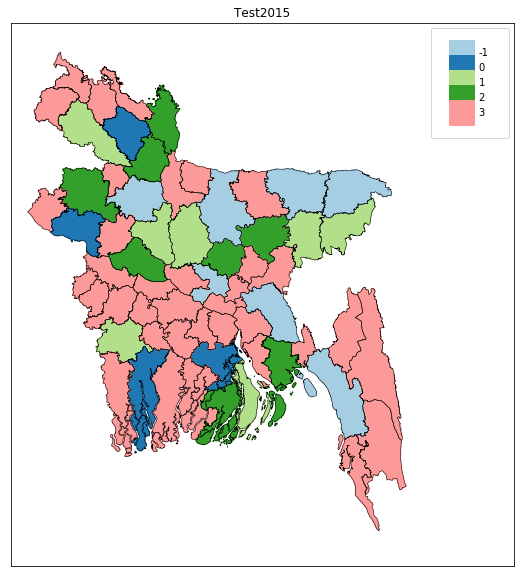

[2016]


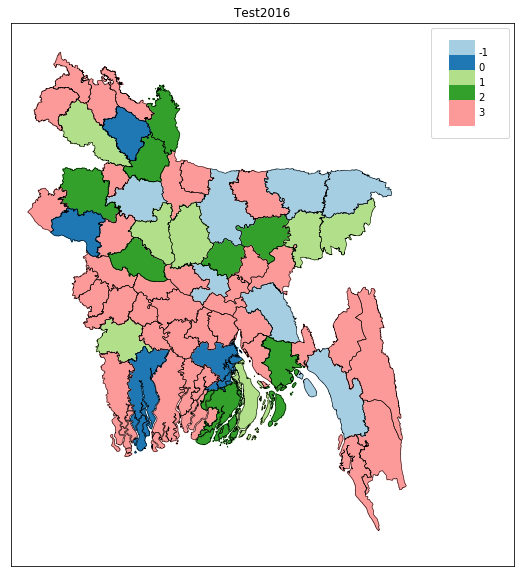

[2017]


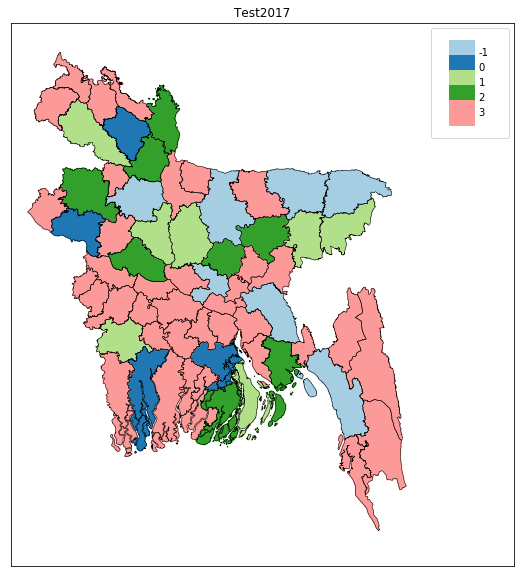

In [85]:
plot_clusters(input_df=datad, shapefile=SHAPEFILE, geo_level=GEO_LEVEL, project=Config.project, output=OUTPUT)

### STEP 9: Getting statistics

In [86]:
datad.head()

,no_births,no_live_births,no_registered_births,prop_registered_births,prop_attendant_delivery,no_deaths,no_deaths_rural,prop_deaths_rural,no_deaths_<5y,no_deaths_1-4y,...,rate_fertility,rate_death,rate_child_death,rate_under5y_mortality,rate_infant_mortality,rate_maternal_mortality,year,geo,class,colors
0,229,225,15,0.07,0.79,53,41,0.77,6,0,...,67.91,4.23,0.0,26.67,26.67,0.0,2015,4001,3,#fb9a99
1,229,225,15,0.07,0.79,53,41,0.77,6,0,...,67.91,4.23,0.0,26.67,26.67,0.0,2016,4001,3,#fb9a99
2,229,225,15,0.07,0.79,53,41,0.77,6,0,...,67.91,4.23,0.0,26.67,26.67,0.0,2017,4001,3,#fb9a99
3,91,91,0,0.00,0.60,15,10,0.67,4,3,...,74.65,3.23,10.6,43.96,10.99,0.0,2015,2003,3,#fb9a99
4,91,91,0,0.00,0.60,15,10,0.67,4,3,...,74.65,3.23,10.6,43.96,10.99,0.0,2016,2003,3,#fb9a99


In [92]:
stats = get_statistics(input_df=datad, output=OUTPUT, title=Config.project)

no_births
no_live_births
no_registered_births
prop_registered_births
prop_attendant_delivery
no_deaths
no_deaths_rural
prop_deaths_rural
no_deaths_<5y
no_deaths_1-4y
no_deaths_<1y
no_maternal_deaths
total_pop
prop_pop_rural
prop_pop_women
pop_>15y
pop_15-19y
pop_>35y
women_15-19y
women_15-45y
women_15-49y
men_>15y
women_15-45_men_>=15y
child_<5y
child_1-4y
child_0-5y
no_married_>=15y
prop_married_>=15y
rate_live_births
rate_fertility
rate_death
rate_child_death
rate_under5y_mortality
rate_infant_mortality
rate_maternal_mortality
no_births
no_live_births
no_registered_births
prop_registered_births
prop_attendant_delivery
no_deaths
no_deaths_rural
prop_deaths_rural
no_deaths_<5y
no_deaths_1-4y
no_deaths_<1y
no_maternal_deaths
total_pop
prop_pop_rural
prop_pop_women
pop_>15y
pop_15-19y
pop_>35y
women_15-19y
women_15-45y
women_15-49y
men_>15y
women_15-45_men_>=15y
child_<5y
child_1-4y
child_0-5y
no_married_>=15y
prop_married_>=15y
rate_live_births
rate_fertility
rate_death
rate_child_death

{2015: class           -1            0           1           2           3  \
 mean    876.142857   907.750000  408.285714  342.375000  206.421053   
 std     352.353718   185.605989   68.443929  121.020586   87.533355   
 amax   1373.000000  1080.000000  482.000000  524.000000  437.000000   
 amin    534.000000   716.000000  287.000000  163.000000   80.000000   
 mean    860.857143   892.250000  400.285714  336.500000  201.973684   
 std     349.723428   185.641904   66.364434  119.663815   85.705494   
 amax   1352.000000  1070.000000  472.000000  515.000000  430.000000   
 amin    517.000000   703.000000  283.000000  158.000000   73.000000   
 mean     23.714286    27.250000   19.428571   17.625000    4.236842   
 std      24.857690    19.172463   14.455185   26.997024    4.226264   
 amax     71.000000    50.000000   45.000000   79.000000   15.000000   
 amin      1.000000     9.000000    2.000000    0.000000    0.000000   
 mean      0.022857     0.032500    0.052857    0.038750  